In [56]:
words = open('names.txt').read().splitlines()
words = list(set(words)) # deduplicate
len(words)

29494

In [57]:
b = {}
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


sorted(b.items(), key=lambda x: x[1], reverse=True)[:20]

[(('a', '.'), 6474),
 (('n', '.'), 6003),
 (('a', 'n'), 5093),
 (('.', 'a'), 4131),
 (('e', '.'), 3641),
 (('e', 'l'), 3073),
 (('a', 'r'), 3009),
 (('n', 'a'), 2910),
 (('r', 'i'), 2761),
 (('.', 'k'), 2689),
 (('l', 'e'), 2677),
 (('l', 'a'), 2473),
 (('m', 'a'), 2427),
 (('a', 'l'), 2417),
 (('e', 'n'), 2402),
 (('.', 'm'), 2375),
 (('l', 'i'), 2346),
 (('i', 'a'), 2335),
 (('h', '.'), 2304),
 (('a', 'h'), 2240)]

In [58]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}


In [59]:
import torch

N = torch.zeros((27,27), dtype=torch.int32)
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (stoi[ch1], stoi[ch2])
        N[bigram] += 1


# frequency as probability

In [60]:
P = N / N.sum(dim=-1, keepdim=True)

(-0.5, 26.5, 26.5, -0.5)

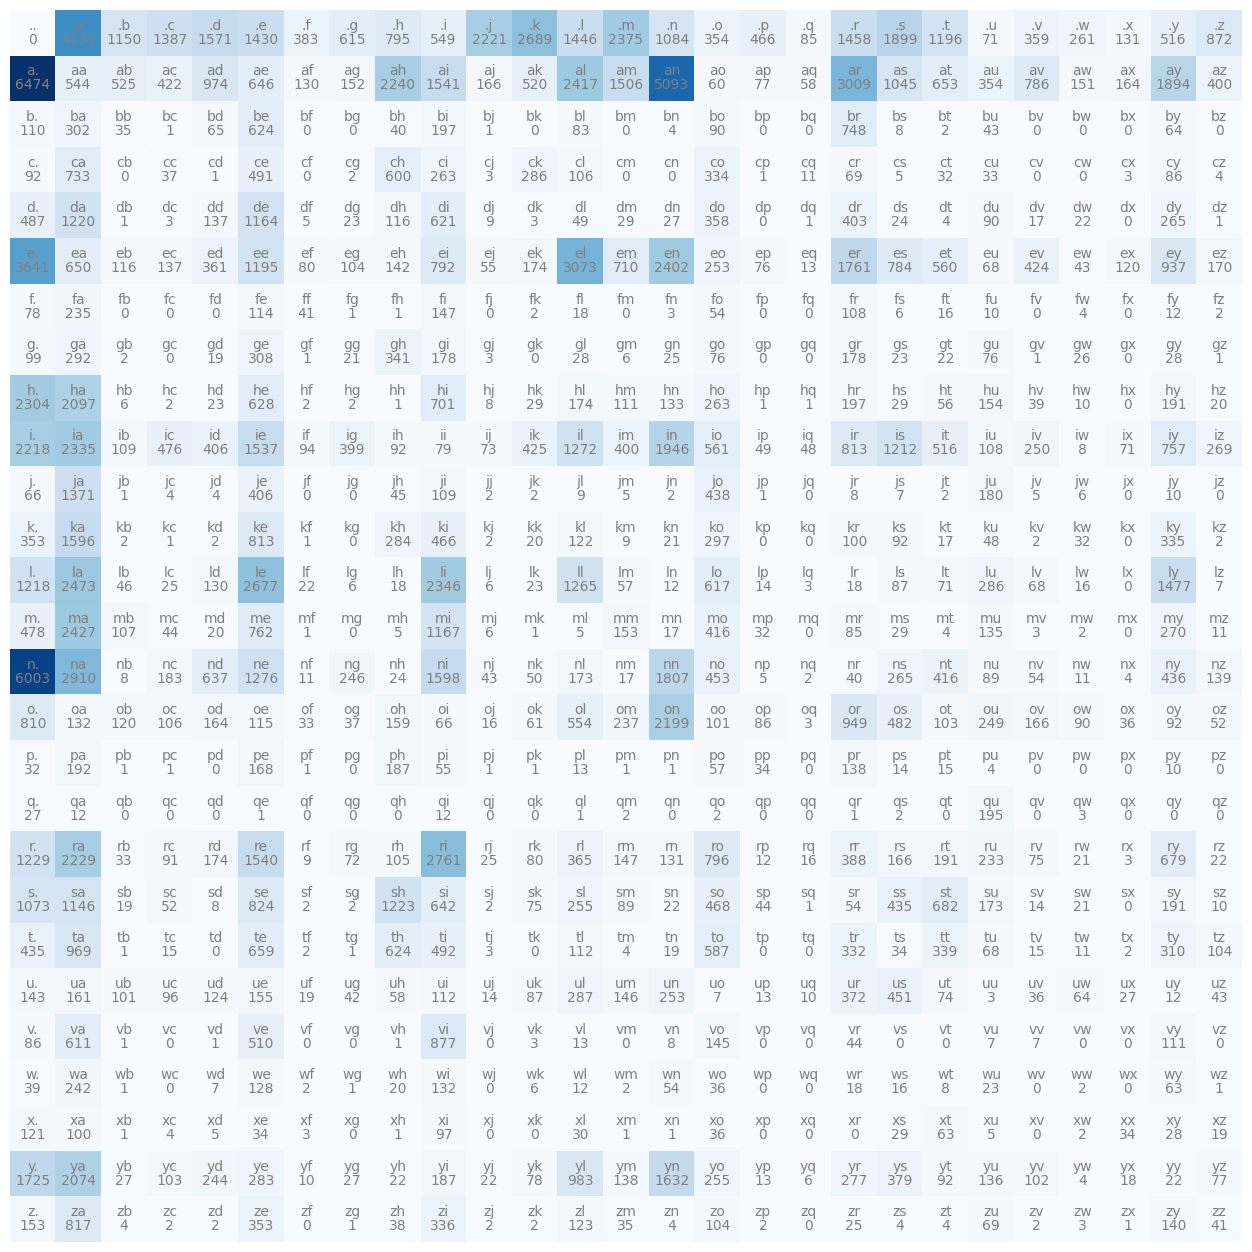

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")

plt.axis('off')

In [62]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = P[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.a.
.feeenvi.
.s.
.mabian.
.dan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.


In [63]:
nll = 0.0
n = 0
for w in ['xiaojq']:
    w = ['.'] + list(w) + ['.']
    for tk, next_tk in zip(w, w[1:]):
        prob = P[stoi[tk], stoi[next_tk]]
        print(f'{tk}{next_tk} prob: {prob:.4f} nll: {-prob.log():.4f}')
        nll += -prob.log()
        n += 1
print(f'{nll=}')
f'{nll/n=}'

.x prob: 0.0044 nll: 5.4167
xi prob: 0.1580 nll: 1.8453
ia prob: 0.1413 nll: 1.9567
ao prob: 0.0019 nll: 6.2792
oj prob: 0.0022 nll: 6.1117
jq prob: 0.0000 nll: inf
q. prob: 0.1047 nll: 2.2571
nll=tensor(inf)


'nll/n=tensor(inf)'

# use neural network to learn probability

In [64]:
import random

# train set
random.seed(42)
random.shuffle(words)
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)

## use off-the-shelf torch api

### minibatch

In [65]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
net = nn.Sequential(
    nn.Embedding(27, 27),
    # nn.GELU(),
    # nn.Linear(27, 27),
)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=512)

for epoch in range(3):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True) # re-shuffle
    for step, (xb, yb) in enumerate(train_dataloader):
        loss = F.cross_entropy(net(xb), yb)
        if step % 100 == 0:
            with torch.no_grad():
                val_loss = 0.0
                num = 0
                for xb, yb in val_dataloader:
                    val_loss += F.cross_entropy(net(xb), yb)
                    num += 1
                val_loss /= num
            print(f'epoch {epoch} step {step} train loss: {loss:.4f} val loss: {val_loss:.4f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



epoch 0 step 0 train loss: 3.6464 val loss: 3.7091
epoch 0 step 100 train loss: 2.9494 val loss: 3.0787
epoch 0 step 200 train loss: 2.6810 val loss: 2.7651
epoch 0 step 300 train loss: 2.5831 val loss: 2.6134
epoch 0 step 400 train loss: 2.5360 val loss: 2.5441
epoch 0 step 500 train loss: 2.6855 val loss: 2.5128
epoch 0 step 600 train loss: 2.5364 val loss: 2.4960
epoch 0 step 700 train loss: 2.3971 val loss: 2.4858
epoch 0 step 800 train loss: 2.3690 val loss: 2.4794
epoch 0 step 900 train loss: 2.3941 val loss: 2.4756
epoch 0 step 1000 train loss: 2.5422 val loss: 2.4721
epoch 0 step 1100 train loss: 2.4137 val loss: 2.4702
epoch 0 step 1200 train loss: 2.4642 val loss: 2.4690
epoch 0 step 1300 train loss: 2.4774 val loss: 2.4682
epoch 0 step 1400 train loss: 2.7194 val loss: 2.4677
epoch 0 step 1500 train loss: 2.2736 val loss: 2.4663
epoch 1 step 0 train loss: 2.3698 val loss: 2.4663
epoch 1 step 100 train loss: 2.4460 val loss: 2.4649
epoch 1 step 200 train loss: 2.3537 val loss

### full batch

In [66]:
torch.manual_seed(42)
net = nn.Sequential(
    nn.Embedding(27, 27),
)
optimizer = torch.optim.AdamW(net.parameters(), lr=1)
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))

for epoch in range(100):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True) # re-shuffle
    for step, (xb, yb) in enumerate(train_dataloader):
        loss = F.cross_entropy(net(xb), yb)
        if step % 100 == 0:
            with torch.no_grad():
                val_loss = 0.0
                num = 0
                for xb, yb in val_dataloader:
                    val_loss += F.cross_entropy(net(xb), yb)
                    num += 1
                val_loss /= num
            print(f'epoch {epoch} step {step} train loss: {loss:.4f} val loss: {val_loss:.4f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



epoch 0 step 0 train loss: 3.6893 val loss: 3.7095
epoch 1 step 0 train loss: 2.9057 val loss: 2.9179
epoch 2 step 0 train loss: 2.6218 val loss: 2.6286
epoch 3 step 0 train loss: 2.5848 val loss: 2.5906
epoch 4 step 0 train loss: 2.6085 val loss: 2.6159
epoch 5 step 0 train loss: 2.6316 val loss: 2.6417
epoch 6 step 0 train loss: 2.6244 val loss: 2.6369
epoch 7 step 0 train loss: 2.5998 val loss: 2.6134
epoch 8 step 0 train loss: 2.5788 val loss: 2.5919
epoch 9 step 0 train loss: 2.5655 val loss: 2.5765
epoch 10 step 0 train loss: 2.5560 val loss: 2.5642
epoch 11 step 0 train loss: 2.5484 val loss: 2.5542
epoch 12 step 0 train loss: 2.5403 val loss: 2.5445
epoch 13 step 0 train loss: 2.5303 val loss: 2.5337
epoch 14 step 0 train loss: 2.5198 val loss: 2.5227
epoch 15 step 0 train loss: 2.5106 val loss: 2.5133
epoch 16 step 0 train loss: 2.5047 val loss: 2.5074
epoch 17 step 0 train loss: 2.5018 val loss: 2.5048
epoch 18 step 0 train loss: 2.4991 val loss: 2.5030
epoch 19 step 0 train 

In [67]:
# bigram val loss
N = torch.zeros((27,27), dtype=torch.int32)
for x, y in train_data:
    N[x, y] += 1
P = N / N.sum(dim=-1, keepdim=True)

val_loss = 0.0
num = 0
for x, y in val_data:
    val_loss += -P[x, y].log()
    num += 1
val_loss /= num
print(f'bigram val loss: {val_loss:.4f}')


bigram val loss: 2.4610


In [68]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = net(idx[-1]).softmax(dim=-1)
        idx_next = torch.multinomial(prob, 1, generator=g)
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.a.
.feeenvi.
.s.
.mabian.
.dan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.


same as sampling from frequency bigram

In [69]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = P[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.a.
.feeenvi.
.s.
.mabian.
.dan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.


(-0.5, 26.5, 26.5, -0.5)

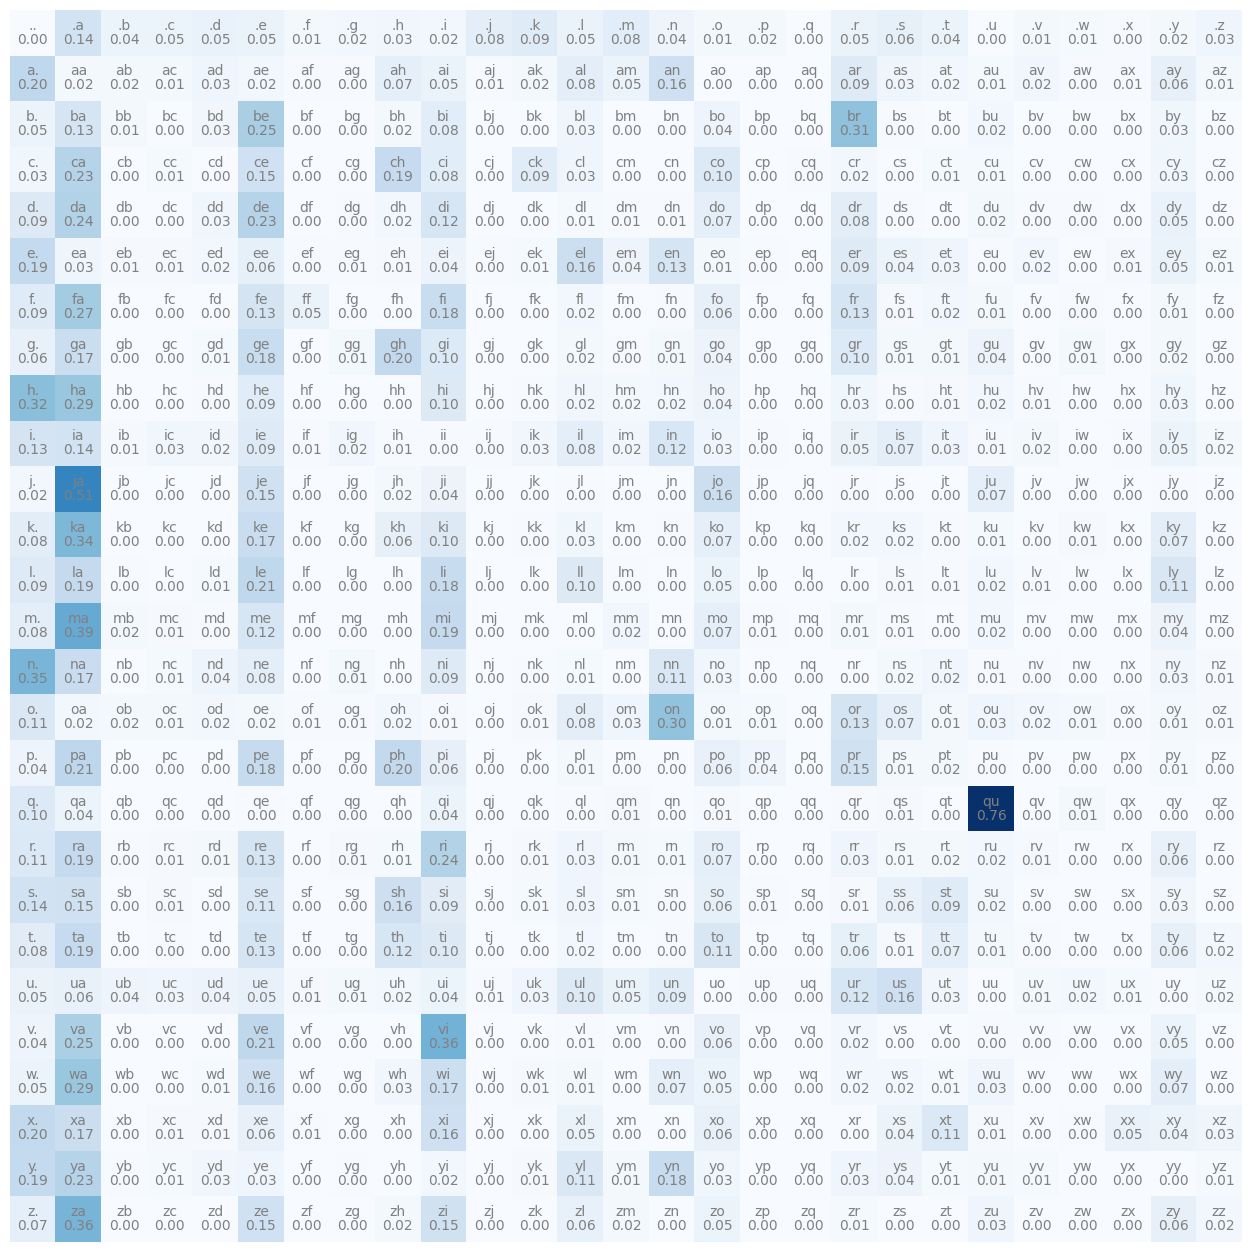

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

netP = net(torch.arange(27)).softmax(dim=-1).detach().numpy()
plt.figure(figsize=(16,16))
plt.imshow(netP, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{netP[i,j]:.2f}', ha="center", va="top", color="gray")

plt.axis('off')


(-0.5, 26.5, 26.5, -0.5)

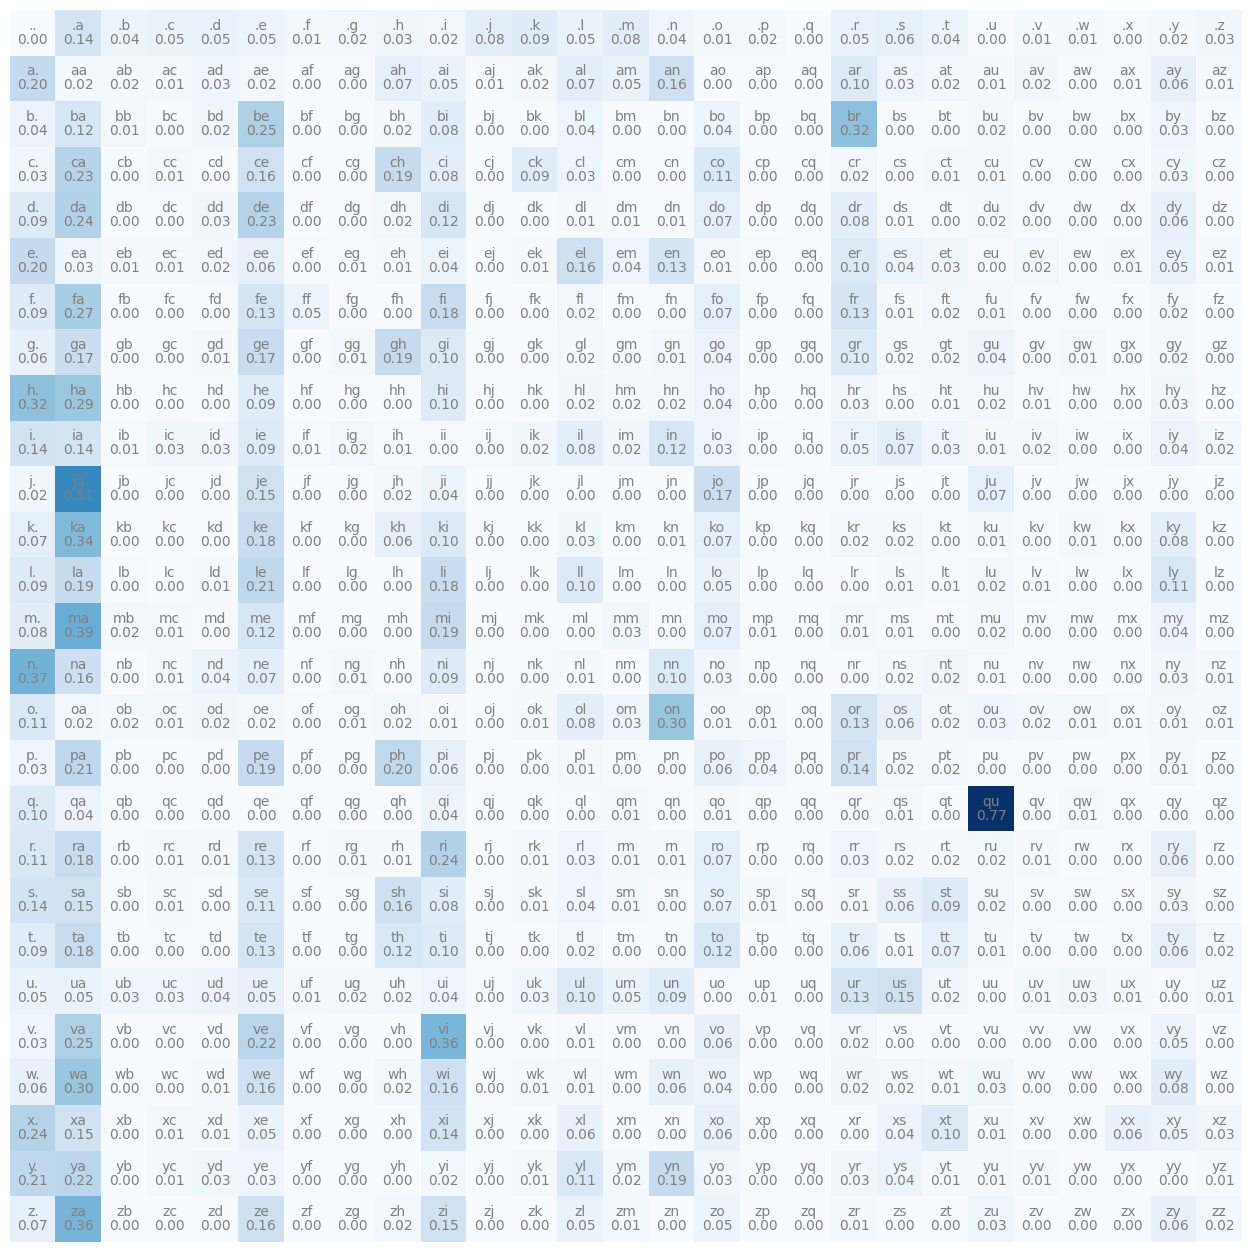

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{P[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

In [71]:
torch.allclose(torch.from_numpy(netP), P, atol=1e-2), torch.allclose(torch.from_numpy(netP), P, atol=1e-3)


(True, False)

## use neural network from matrix multiplication

In [72]:
# from scratch
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), requires_grad=True, generator=g)


n = int(len(xs) * 0.95)
xs, ys = torch.tensor(xs), torch.tensor(ys)

def cal_loss(xb, yb):
    xb = F.one_hot(xb, num_classes=27).float()
    logits = xb @ W
    exp_lg = logits.exp()
    probs = exp_lg / exp_lg.sum(dim=-1, keepdim=True)
    loss = -probs.gather(1, yb.unsqueeze(-1)).log().mean()
    return loss

lr = 50.0
num_epochs = 5000
for epoch in range(num_epochs):
    loss = cal_loss(xs[:n], ys[:n])
    if epoch % 100 == 0:
        with torch.no_grad():
            eval_loss = cal_loss(xs[n:], ys[n:])
        print(f'epoch {epoch} loss: {loss:.4f} eval loss: {eval_loss:.4f}')
    # update
    loss.backward()
    W.data -= lr * W.grad
    W.grad = None




/var/folders/0r/_r1qbh850_g0pzpgx1lg9_q40000gn/T/ipykernel_98264/2190405965.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs, ys = torch.tensor(xs), torch.tensor(ys)


epoch 0 loss: 3.6893 eval loss: 3.7095
epoch 100 loss: 2.4721 eval loss: 2.4800
epoch 200 loss: 2.4618 eval loss: 2.4697
epoch 300 loss: 2.4586 eval loss: 2.4662
epoch 400 loss: 2.4571 eval loss: 2.4646
epoch 500 loss: 2.4563 eval loss: 2.4636
epoch 600 loss: 2.4557 eval loss: 2.4631
epoch 700 loss: 2.4553 eval loss: 2.4627
epoch 800 loss: 2.4550 eval loss: 2.4624
epoch 900 loss: 2.4548 eval loss: 2.4622
epoch 1000 loss: 2.4547 eval loss: 2.4620
epoch 1100 loss: 2.4545 eval loss: 2.4619
epoch 1200 loss: 2.4544 eval loss: 2.4618
epoch 1300 loss: 2.4543 eval loss: 2.4617
epoch 1400 loss: 2.4542 eval loss: 2.4617
epoch 1500 loss: 2.4542 eval loss: 2.4616
epoch 1600 loss: 2.4541 eval loss: 2.4616
epoch 1700 loss: 2.4541 eval loss: 2.4615
epoch 1800 loss: 2.4540 eval loss: 2.4615
epoch 1900 loss: 2.4540 eval loss: 2.4615
epoch 2000 loss: 2.4540 eval loss: 2.4614
epoch 2100 loss: 2.4539 eval loss: 2.4614
epoch 2200 loss: 2.4539 eval loss: 2.4614
epoch 2300 loss: 2.4539 eval loss: 2.4614
epoc

(-0.5, 26.5, 26.5, -0.5)

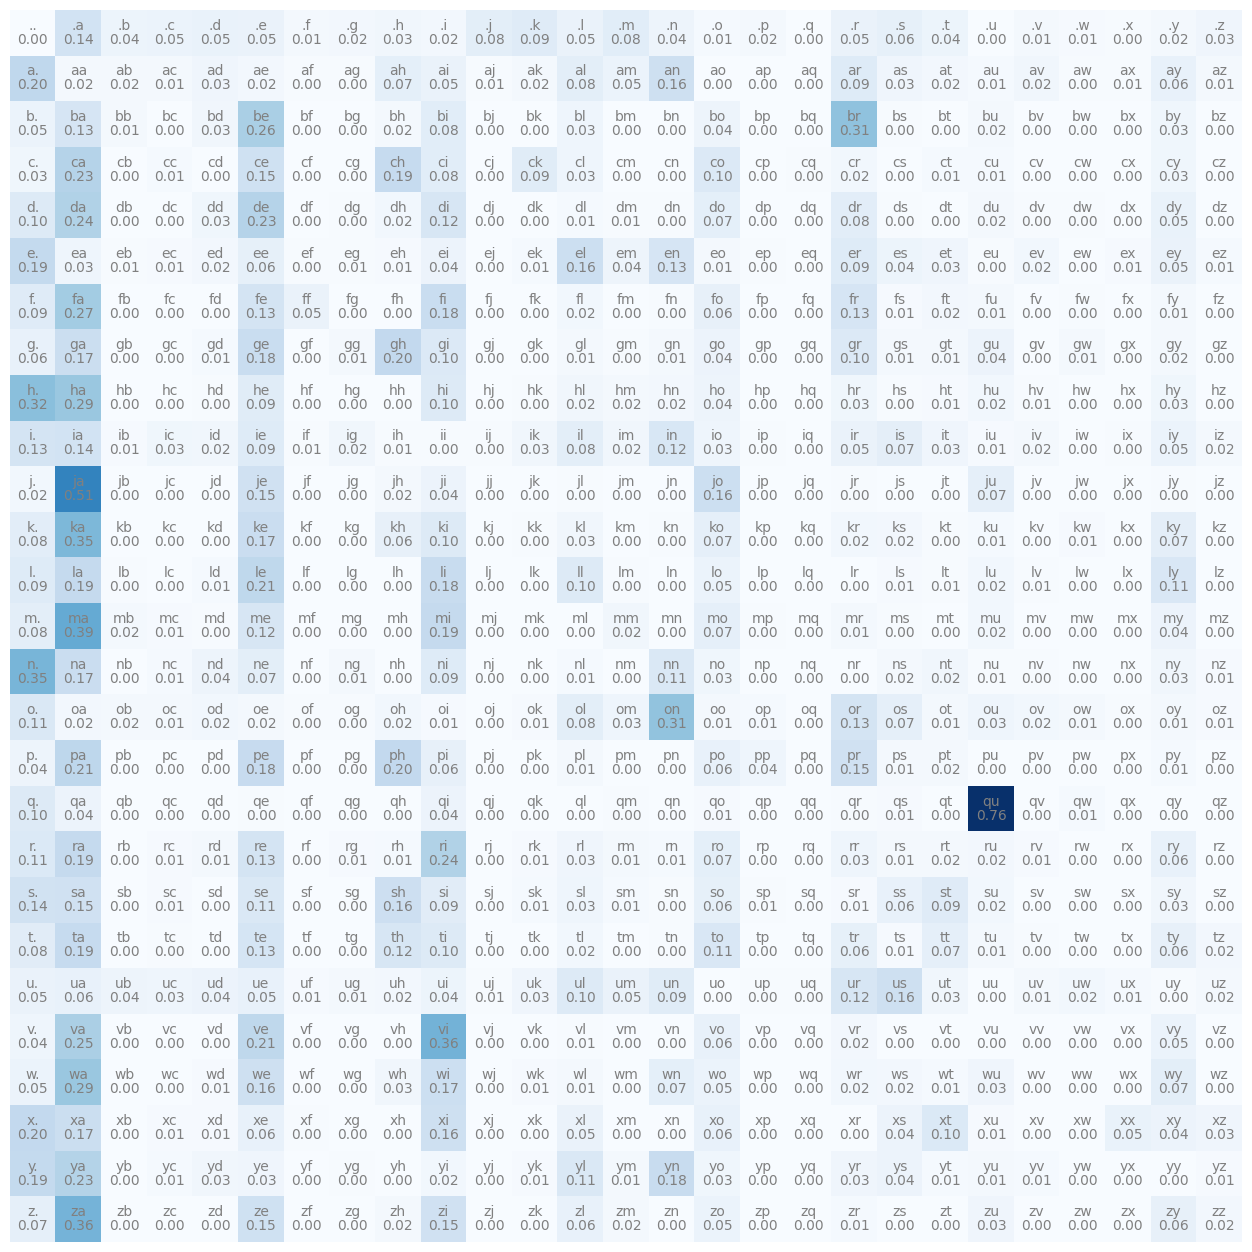

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

PW = W.detach().softmax(dim=-1)

plt.figure(figsize=(16,16))
plt.imshow(PW.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{PW[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

In [74]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = PW[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.a.
.feeenvi.
.s.
.mabian.
.dan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.


In [75]:
torch.allclose(PW, P, atol=1e-2), torch.allclose(PW, P, atol=1e-3)

(True, False)

## use micrograd from scratch

this is slow, but it is a good exercise

In [76]:
# use micrograd from scratch
import random
from micrograd import Value

random.seed(42)
random.shuffle(words)
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]

def cal_loss(xb, yb):
    logits = [W[xb[i]] for i in range(len(xb))] # (bs, 27)
    exp_logits = [[lg.exp() for lg in logit] for logit in logits]
    sum_exp_logits = [sum(exp_logit) for exp_logit in exp_logits] # (bs,)
    probs = [exp_logit[y] / sum_exp_logit for exp_logit, sum_exp_logit, y in zip(exp_logits, sum_exp_logits, yb)]
    loss = sum([-prob.log() for prob in probs]) / len(probs)
    return loss


random.seed(42)
W = [[Value(random.gauss(0,1)) for _ in range(27)] for _ in range(27)]

lr = 50
bs = 1084

step = 0
for epoch in range(3):
    random.shuffle(train_data)
    for idx in range(0, len(train_data), bs):
        xb, yb = zip(*train_data[idx:idx+bs])
        loss = cal_loss(xb, yb)
        if step % 10 == 0:
            xb, yb = zip(*val_data[:bs]) # one batch for efficiency
            val_loss = cal_loss(xb, yb)
            print(f'epoch {epoch} step {step} loss: {loss.data:.4f} val loss: {val_loss.data:.4f}')
        # update
        loss.backward()
        for params in W:
            for p in params:
                p.data -= lr * p.grad
                p.grad = 0.0
        step += 1
        lr = max(50 * (1 - 0.9 * step / 200), 5.0)


epoch 0 step 0 loss: 3.7063 val loss: 3.6763
epoch 0 step 10 loss: 2.6790 val loss: 2.6983
epoch 0 step 20 loss: 2.6193 val loss: 2.5790
epoch 0 step 30 loss: 2.5566 val loss: 2.5543
epoch 0 step 40 loss: 2.5454 val loss: 2.5200
epoch 0 step 50 loss: 2.5178 val loss: 2.5158
epoch 0 step 60 loss: 2.4736 val loss: 2.5086
epoch 0 step 70 loss: 2.5210 val loss: 2.4962
epoch 0 step 80 loss: 2.4836 val loss: 2.4931
epoch 0 step 90 loss: 2.4876 val loss: 2.4918
epoch 0 step 100 loss: 2.4756 val loss: 2.4848
epoch 0 step 110 loss: 2.4983 val loss: 2.4909
epoch 0 step 120 loss: 2.4645 val loss: 2.4855
epoch 0 step 130 loss: 2.4775 val loss: 2.4863
epoch 0 step 140 loss: 2.5645 val loss: 2.4816
epoch 0 step 150 loss: 2.4984 val loss: 2.4856
epoch 0 step 160 loss: 2.4855 val loss: 2.4842
epoch 0 step 170 loss: 2.4830 val loss: 2.4798
epoch 0 step 180 loss: 2.4909 val loss: 2.4812
epoch 1 step 190 loss: 2.4626 val loss: 2.4788
epoch 1 step 200 loss: 2.4133 val loss: 2.4797
epoch 1 step 210 loss: 2

(-0.5, 26.5, 26.5, -0.5)

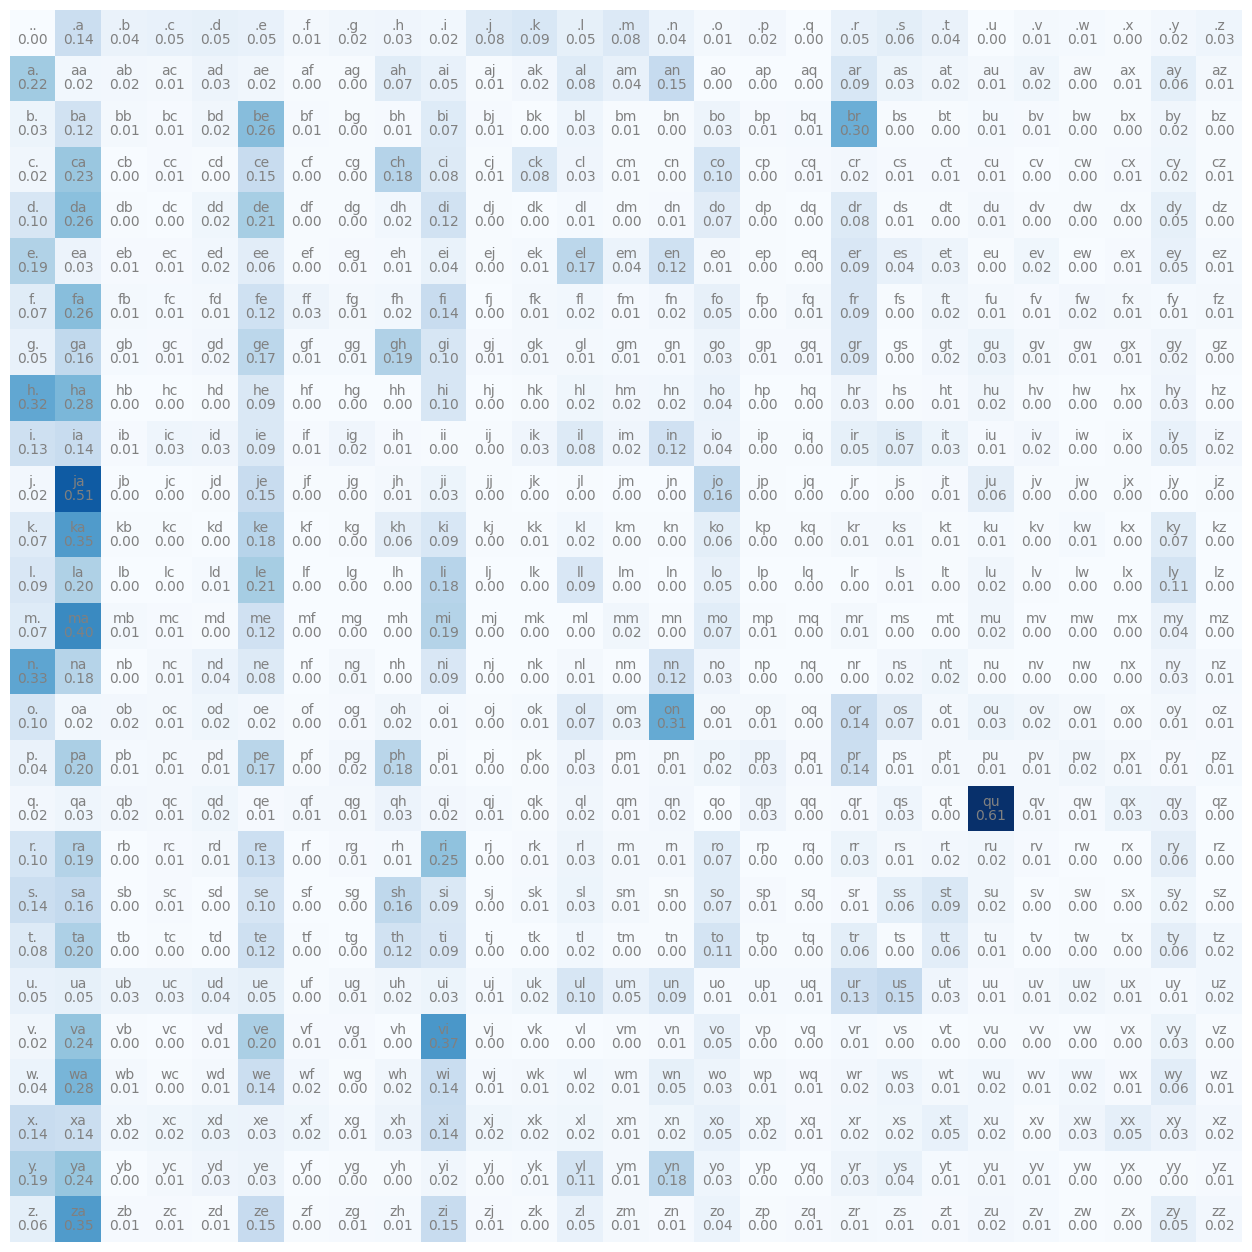

In [77]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

W_data = [[w.data for w in params] for params in W]
PW = torch.tensor(W_data).softmax(dim=-1)

plt.figure(figsize=(16,16))
plt.imshow(PW.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{PW[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

almost same as sampling from frequency bigram

In [78]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = PW[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.a.
.fgeenvi.
.s.
.mabian.
.dxfwe.
.nn.
.silaylelaremah.
.li.
.le.
.epenchalen.


In [79]:
torch.allclose(PW, P, atol=0.2), torch.allclose(PW, P, atol=0.1)


(True, False)